In [41]:
import numpy as np
import seaborn as sns
import ast

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

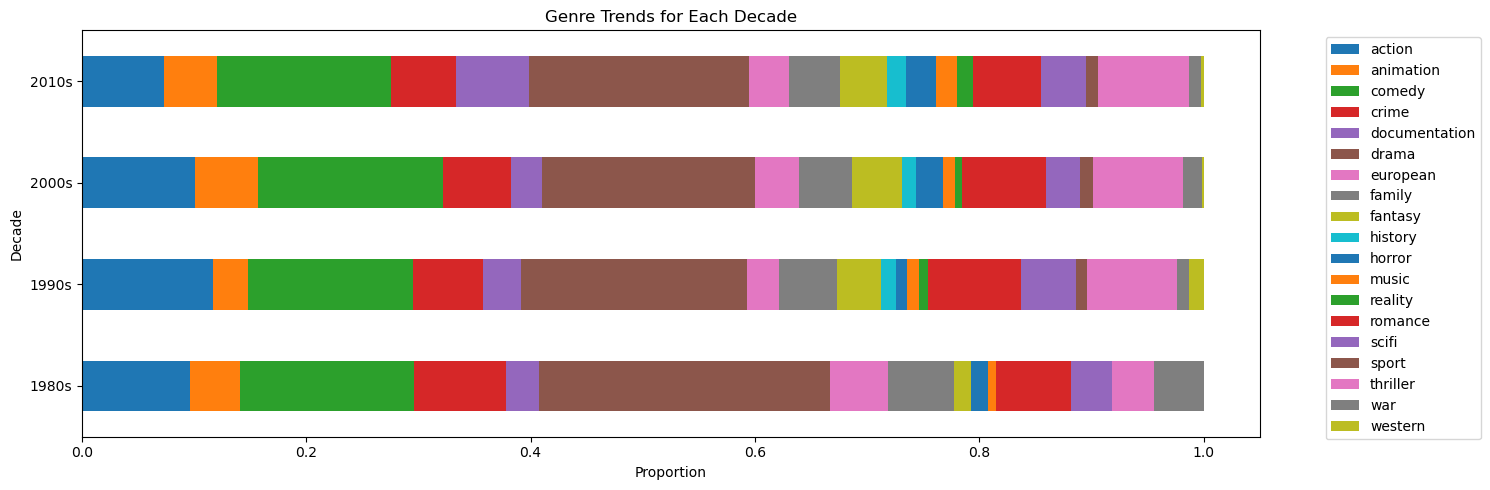

In [42]:
# %load trends_analysis.py
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from ast import literal_eval

# Read csv and make genre column arrays
title_df = pd.read_csv('titles.csv', converters = {'genres': literal_eval})

# Function to bin dataframe by decade
def bin(title_df):
    # Check the min and max years to check which decades to bin
    temp = title_df.min(numeric_only = True)
    text = ['Minimum Release Year: ' + str(int(temp[0]))]

    temp = title_df.max(numeric_only = True)
    text += ['Maximum Release Year: ' + str(int(temp[0]))]

    # As we want to bin each decade, start from 1950 and finish at 2020
    title_df['decades'] = pd.cut(x = title_df['release_year'], 
                                 bins = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030],
                                 labels = [40, 50, 60, 70, 80, 90, 100, 110, 120]) #100 and 110 are our 2000's bins
    
    # Save as csv to use in other programs
    title_df.to_csv('binned_table.csv', index=False)

    # Remove unwanted decades
    title_df = title_df[(title_df['release_year'] > 1950) & (title_df['release_year'] < 2021)]

    # Write to text file
    with open('prelim_info.txt', 'w') as f:
        for line in text:
            f.write(line)
            f.write('\n')
    
    return title_df

# Reference: https://www.geeksforgeeks.org/python-program-for-binary-search/
# Edited binary search function that performs reverse process and returns the index of element with higher alphabetical value
def binary_search(arr, low, high, x):
 
    # Check base case
    if high >= low:
 
        mid = (high + low) // 2
 
        # If element is present at the middle itself
        if arr[mid] == x:
            return -1
 
        # If element is smaller than mid, then it can only
        # be present in left subarray
        elif arr[mid] > x:
            return binary_search(arr, low, mid - 1, x)
 
        # Else the element can only be present in right subarray
        else:
            return binary_search(arr, mid + 1, high, x)
 
    else:
        # Element is not present in the array so output index of element that has higher alphabetical value
        return low

# Function to find all genres
def find_genres(binned_df):
    # Iterate through rows of dataframe
    genres = []

    # Iterate through dataframe rows
    for index, row in binned_df.iterrows():
        # Iterate through each array of genres column
        for element in row['genres']:

            # Check if the element is contained within genres list
            output = binary_search(genres, 0, len(genres) - 1, element)
            if (output != -1):
                # If so insert in alphabetical order
                genres.insert(output, element)
    
    return genres

# Function to count total number of genres
def count_genres(binned_df, genres):
    count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # Iterate through dataframe rows
    for index, row in binned_df.iterrows():
        # Iterate through each array of genres column
        for element in row['genres']:
            # Count the genre
            count[genres.index(element)] = count[genres.index(element)] + 1
    
    # Make a dataframe
    genre_count_df = pd.DataFrame(data = {'genre': genres, 'count': count})

    #print(genre_count_df['genre'][0])
    with open('prelim_info.txt', 'a') as f:
        f.write('\nGenre Count\n')
        for row in genre_count_df.index:
            f.write(genre_count_df['genre'][row])
            f.write(': ')
            f.write(str(genre_count_df['count'][row]))
            f.write('\n')

# Function to calculate proportions of a list
def calc_proportion(count):
    list = []
    sum_count = sum(count)
    for element in count:
        list.append(element/sum_count)
    return list

# Function to count total number of genres for each decade
def count_genres_decades(binned_df, genres, bin, check):
    # Get only value of specific bin
    binned_df = binned_df[binned_df['decades'] == bin]

    count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # Iterate through dataframe rows
    for index, row in binned_df.iterrows():
        # Iterate through each array of genres column
        for element in row['genres']:
            # Count the genre
            count[genres.index(element)] = count[genres.index(element)] + 1
    
    # Make a list which will be our row
    if (check == True):
        list = [bin] + calc_proportion(count)
    # This case is for making dataframe with raw numbers
    else:
        list = [bin] + count

    return list

# Function that creates new dataframe of values to plot
def make_final_df(binned_df, genres, check):
    # Make empty dataframe
    decade_prop_df = pd.DataFrame( columns = ['decade', 'action', 'animation', 'comedy',
                                            'crime', 'documentation', 'drama', 'european',
                                            'family', 'fantasy', 'history', 'horror', 'music',
                                            'reality', 'romance', 'scifi', 'sport',
                                            'thriller', 'war', 'western'])

    # Iterate by number of decades we have chosen to make dataframe
    for count in range(7):
        list = count_genres_decades(binned_df, genres, 50 + 10*count, check)
        # Append new list to dataframe
        decade_prop_df.loc[len(decade_prop_df)] = list

    if (check == True):
        decade_prop_df.to_csv('decade_prop_df.csv', index=False)
    # This case is for making dataframe with raw numbers
    else:
        decade_prop_df.to_csv('decade_count_df.csv', index=False)
    return decade_prop_df

# Function to change decade category values to be more visually appealing
def change_decade_values(decade_prop_df):
    # Iterate through rows
    for row in range(len(decade_prop_df)):
        str1 = ''
        # Calculate the decade
        num = float(80 + 10*row)
        #num = float(50 + 10*row)
        # If bin is in the 2000's
        if (num >= 100):
            num = num - 100
            if (num == 0):
                str1 = '200' + str(int(num))
            else:
                str1 = '20' + str(int(num))
        # If bin is in 1900s
        else:
            str1 = '19' + str(int(num))
        # Replace the old bins with proper decades
        decade_prop_df.replace(float(80 + 10*row), str1 + 's', inplace = True)
        #decade_prop_df.replace(float(50 + 10*row), str1 + 's', inplace = True)

# Plot data
def plot_data(decade_prop_df):
    decade_prop_df.plot(x = 'decade', kind = 'barh', stacked = True, title = 'Genre Trends for Each Decade', 
                         mark_right = True, figsize=(15,5))
    plt.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')
    plt.xlabel("Proportion")
    plt.ylabel("Decade")
    plt.tight_layout()
    plt.savefig('graph.png')

# Call functions

binned_df = bin(title_df)

genres = find_genres(binned_df)

count_genres(binned_df, genres)

decade_prop_df = make_final_df(binned_df, genres, True)

# For teammates
decade_count_df = make_final_df(binned_df, genres, False)

# There are too few data points for the 50s, 60s and 70s so remove them
decade_prop_df = decade_prop_df[decade_prop_df['decade'] > 70]

change_decade_values(decade_prop_df)

plot_data(decade_prop_df)

In [43]:
# Loading the 'credits.csv' file into a DataFrame named 'credit'
credit = pd.read_csv("credits.csv")
# Loading the 'titles.csv' file into a DataFrame named 'titles'
titles = pd.read_csv("binned_table.csv")

In [44]:
credit.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [45]:
# Calculate the number of missing values for each column in 'titles' DataFrame
missing_data = titles.isna().sum()
print(missing_data)

id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
decades                    0
dtype: int64


In [46]:
# Remove the column named 'title' from the 'titles' dataframe and store in a new dataframe df_cleaned
df_cleaned = titles.dropna(subset = ['title'])

In [47]:
# Calculate the mean of 4 columns named'imdb socre, imdb votes, tmdb popularity and tmdb score' and fill the missing values in each columns with its mean value in the cleaned dataframe 'df_cleand'
imdb_score_mean = df_cleaned['imdb_score'].mean()
imdb_votes_mean = df_cleaned['imdb_votes'].mean()
tmdb_popularity_mean = df_cleaned['tmdb_popularity'].mean()
tmdb_score_mean = df_cleaned['tmdb_score'].mean()

df_cleaned['imdb_score'].fillna(imdb_score_mean, inplace = True)
df_cleaned['imdb_votes'].fillna(imdb_votes_mean, inplace = True)
df_cleaned['tmdb_popularity'].fillna(tmdb_popularity_mean, inplace = True)
df_cleaned['tmdb_score'].fillna(tmdb_score_mean, inplace = True)

In [48]:
# Check the amount of missing values in each column after processed the missing data
df_cleaned.isna().sum()

id                         0
title                      0
type                       0
description               17
release_year               0
age_certification       2618
runtime                    0
genres                     0
production_countries       0
seasons                 3743
imdb_id                  403
imdb_score                 0
imdb_votes                 0
tmdb_popularity            0
tmdb_score                 0
decades                    0
dtype: int64

In [50]:
df_cleaned['genres']

0                                 ['documentation']
1                                ['drama', 'crime']
2       ['drama', 'action', 'thriller', 'european']
3                   ['fantasy', 'action', 'comedy']
4                                 ['war', 'action']
                           ...                     
5845                           ['romance', 'drama']
5846                                      ['drama']
5847                                     ['comedy']
5848                                             []
5849              ['family', 'animation', 'comedy']
Name: genres, Length: 5849, dtype: object

In [38]:
# Apply to each element in the column named 'genres', if it's not a missing value than will be process by the ast function and if it is a missing value it will assign a empty list to prevent a error due to unable 
# to evalaute while processing.
df_cleaned['genres'] = df_cleaned['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

In [39]:
# Check the data tyoe if element in column 'genre' after preprocessed
df_cleaned['genres'][0][0]

'documentation'

In [40]:
# Undergo one hot encoding to put all outcomes in the 'genres' column in to a new column objects fall under one or more specifc genre will present a 1 under corresponding column otherwise an 0.
genres_dummies = pd.get_dummies(df_cleaned['genres'].explode(), prefix='genre')
genres_dummies = genres_dummies.groupby(level=0).sum()
# Contact the new dummie variables with the previous data frame 'df_cleaned' name 'df_encoded'
df_encoded = pd.concat([df_cleaned, genres_dummies], axis=1)
# Display the new data frame
df_encoded

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,genre_history,genre_horror,genre_music,genre_reality,genre_romance,genre_scifi,genre_sport,genre_thriller,genre_war,genre_western
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,[documentation],['US'],1.0,...,0,0,0,0,0,0,0,0,0,0
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"[drama, crime]",['US'],NaN,...,0,0,0,0,0,0,0,0,0,0
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"[drama, action, thriller, european]",['US'],NaN,...,0,0,0,0,0,0,0,1,0,0
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"[fantasy, action, comedy]",['GB'],NaN,...,0,0,0,0,0,0,0,0,0,0
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"[war, action]","['GB', 'US']",NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"[romance, drama]",['NG'],NaN,...,0,0,0,0,1,0,0,0,0,0
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,[drama],[],NaN,...,0,0,0,0,0,0,0,0,0,0
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,[comedy],['CO'],NaN,...,0,0,0,0,0,0,0,0,0,0
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,[],['US'],NaN,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Create sepreate rows for each different genre for rows where 'genres' contains multiple genre labels
df_exploded = df_encoded.explode('genres')
# Calculate the number of the occurrences of each genre in the 'genres' column to provided an clear view of how many shows or movies fall under each genre.
genres_counts = df_exploded['genres'].value_counts()
print(genres_counts)

drama            2406
comedy           1907
thriller          983
action            956
romance           772
documentation     726
crime             718
animation         576
family            558
fantasy           505
scifi             473
european          439
horror            312
music             210
history           206
reality           162
war               144
sport             129
western            36
Name: genres, dtype: int64


In [15]:
# Remove the columns of data which is useless. genres are also now useless cause we created a unique column for each genre.
droped = ['seasons', 'age_certification', 'genres', 'imdb_id']
df_cleaned = df_encoded.drop(columns = droped)

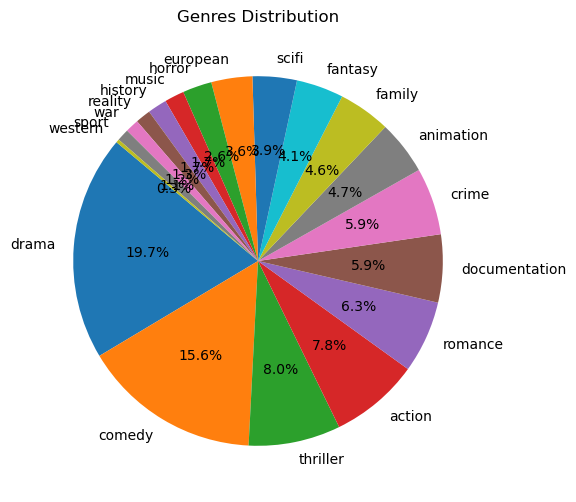

In [16]:
# Aet up a specified size
plt.figure(figsize=(6,6))
# Create a bar chart with the genre names as lables of each segment and a set format for precentage each segment took abd rotated start of the chart to make it look nicer
plt.pie(genres_counts, labels = genres_counts.index, autopct='%1.1f%%', startangle = 140)
# Set the title for the pie chart 'Genres Distribution'
plt.title('Genres Distribution')
# Display the pie chart
plt.show()

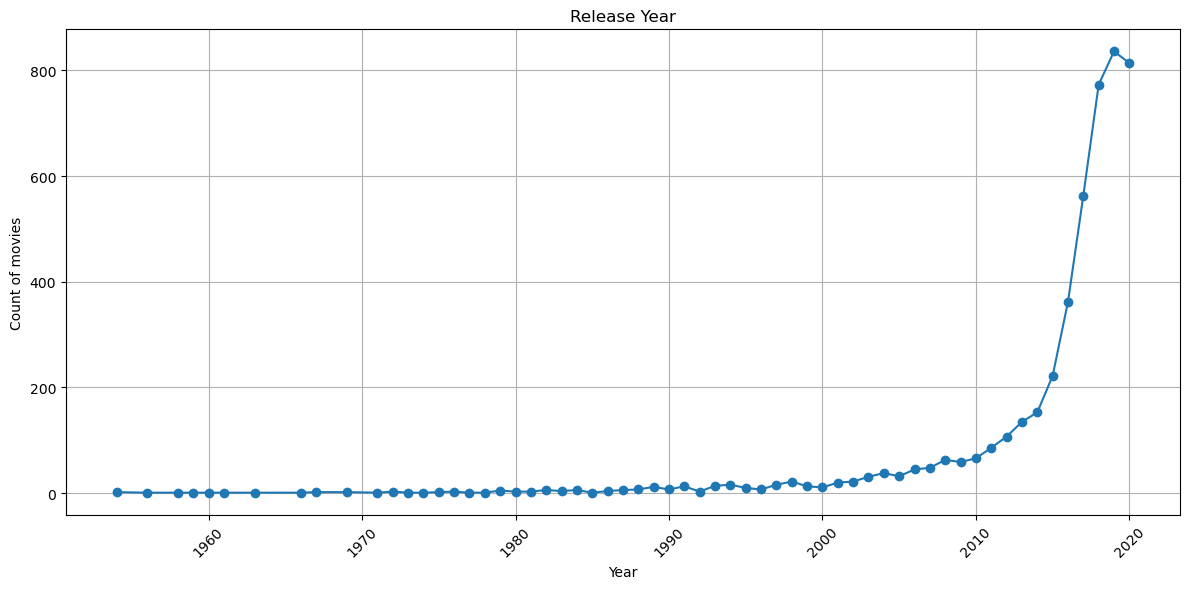

In [17]:
# Compute the count of movies for each 'release_year' and sort the counts by year.
year_counts = df_cleaned['release_year'].value_counts().sort_index()
# Plot data
fig, axis = plt.subplots(figsize = (12, 6))
axis.plot(year_counts.index, year_counts.values, marker = 'o', linestyle = '-')
axis.set_title('Release Year')
axis.set_xlabel('Year')
axis.set_ylabel('Count of movies')
axis.tick_params(axis = 'x', rotation = 45)  
axis.grid(True)
plt.tight_layout()
plt.show()

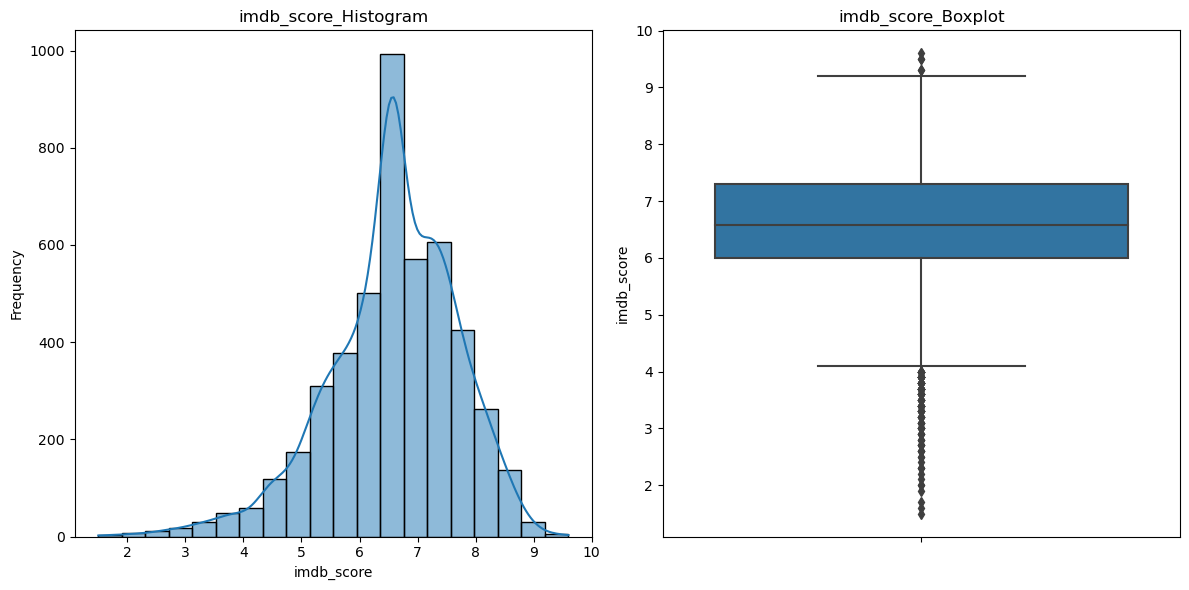

In [18]:
# Plot data
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['imdb_score'], bins = 20, kde = True).set(title = 'imdb_score_Histogram', xlabel = 'imdb_score', ylabel = 'Frequency')
plt.subplot(1, 2, 2)
sns.boxplot(y = df_cleaned['imdb_score']).set(title = 'imdb_score_Boxplot', ylabel = 'imdb_score')
plt.tight_layout()
plt.show()

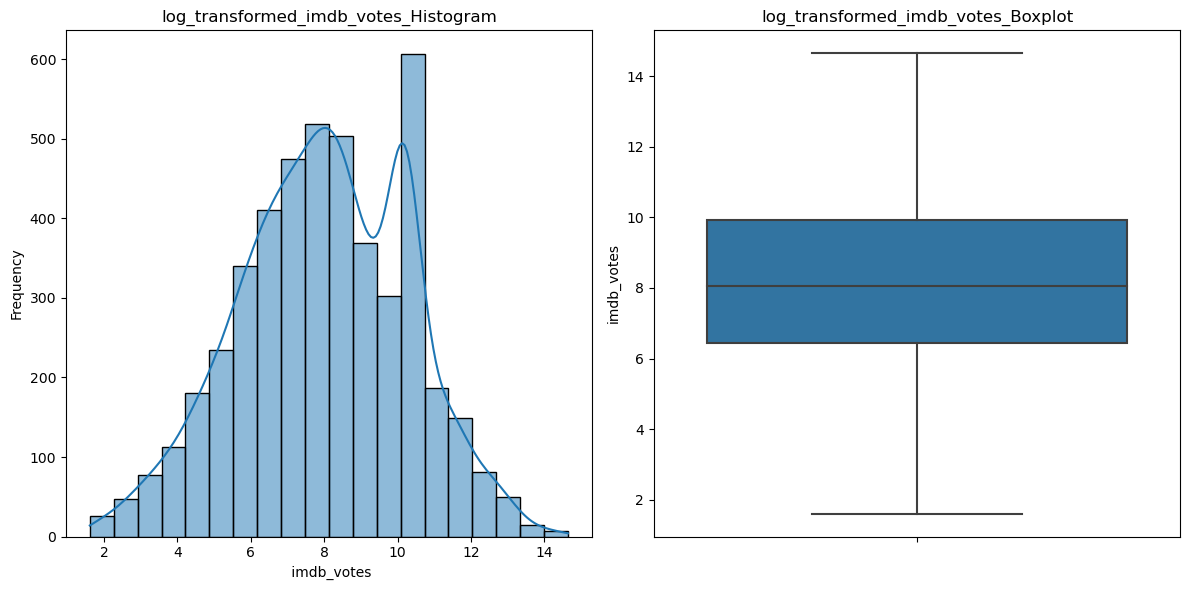

In [19]:
# Plot data
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
# Undergoes a log tranformed to 'imdb_votes' due to the orginal datas are too skewed.
sns.histplot(np.log(df_cleaned['imdb_votes']), bins = 20, kde = True).set(title = 'log_transformed_imdb_votes_Histogram', xlabel =' imdb_votes', ylabel = 'Frequency')
plt.subplot(1, 2, 2) 
sns.boxplot(y = np.log(df_cleaned['imdb_votes'])).set(title = 'log_transformed_imdb_votes_Boxplot', ylabel = 'imdb_votes')
plt.tight_layout()
plt.show()


In [20]:
# Encode the column 'types' in to numbers for steps afterwards
label_encoder = LabelEncoder()
df_cleaned['type'] = label_encoder.fit_transform(df_cleaned['type'])

In [21]:
# Normalize the numerical datas we needed
scaler = StandardScaler()
scaler_column = ['release_year','imdb_score','imdb_votes']
df_cleaned[scaler_column] = scaler.fit_transform(df_cleaned[scaler_column])

In [22]:
# Finalize the preprocessed dataframe decide which columns are needed.
kept_col = ['type', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score', 'genre_action', 'genre_animation', 'genre_crime', 'genre_comedy', 'genre_documentation', 'genre_drama', 'genre_european', 
            'genre_family', 'genre_fantasy', 'genre_history', 'genre_horror', 'genre_music', 'genre_reality', 'genre_scifi', 'genre_romance', 'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']
df_final = df_cleaned[kept_col]

In [23]:
# Display the final dataframe.
df_final

,type,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre_action,genre_animation,genre_crime,genre_comedy,genre_documentation,...,genre_history,genre_horror,genre_music,genre_reality,genre_scifi,genre_romance,genre_sport,genre_thriller,genre_war,genre_western
0,0,1.466813e+00,7.724238e+00,40.965,8.179,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.016799e+00,7.970575e-01,10.010,7.300,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1.466813e+00,5.015309e+00,15.461,7.811,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1.016799e+00,4.510389e-01,20.398,7.600,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2.006830e+00,4.585699e-01,17.617,8.306,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4686,0,-1.863293e+00,-2.668426e-01,1.970,7.700,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4687,1,1.016799e+00,-2.667438e-01,0.900,10.000,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4688,0,-1.053267e+00,-2.520179e-01,2.169,7.500,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4689,0,-6.323567e-02,-2.657653e-01,3.299,6.900,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#  drop the spefic columns and use the rest of them in data frame df_final as feature varibale y and imdb_score the target variable X
X = df_final.drop(columns=['imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'])
y = df_final['imdb_score']
# Split the dataset into training and testing sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model evaluation
linear_regression = LinearRegression()
# Perform 10-fold cross-validation to get negative mean squared error and r^2 scores for the model.
linear_scores = cross_val_score(linear_regression, X, y, cv=10, scoring='neg_mean_squared_error')
linear_r2_scores = cross_val_score(linear_regression, X, y, cv=10, scoring='r2')
# Convert negative mean squared error scores to root mean squared error (RMSE) scores.
linear_rmse_scores = (-linear_scores)**0.5
# Print out the RMSE scores and their mean for the Linear Regression model.
print("Linear Regression Cross-Validation RMSE Scores:", linear_rmse_scores)
print("Mean RMSE:", linear_rmse_scores.mean())
# Print out the R^2 scores and their mean for the Linear Regression model.
print("Linear Regression Cross-Validation R^2 Scores:", linear_r2_scores)
print("Mean R^2:", linear_r2_scores.mean())

print("\n\n")

# RandomForest model evaluation
# Instantiate the RandomForest Regressor model with 100 trees.
forest_regression = RandomForestRegressor(n_estimators=100, random_state=42)
# Perform 10-fold cross-validation to get negative mean squared error and r^2 scores for the RandomForest model.
forest_scores = cross_val_score(forest_regression, X, y, cv=10, scoring='neg_mean_squared_error')
forest_r2_scores = cross_val_score(forest_regression, X, y, cv=10, scoring='r2')
forest_rmse_scores = (-forest_scores)**0.5
# print out the RMSE scores and R^2 scores and their mean for the linear Regression model.
print("Random Forest Cross-Validation RMSE Scores:", forest_rmse_scores)
print("Mean RMSE:", forest_rmse_scores.mean())
print("Random Forest Cross-Validation R^2 Scores:", forest_r2_scores)
print("Mean R^2:", forest_r2_scores.mean())

Linear Regression Cross-Validation RMSE Scores: [0.99580907 0.93248317 0.86216565 0.91150971 0.84509125 0.89774502
 0.88101932 0.86357617 0.92903008 0.95888585]
Mean RMSE: 0.9077315295643726
Linear Regression Cross-Validation R^2 Scores: [-0.05248204  0.12611307  0.23708207  0.22288675  0.19672162  0.0818446
  0.23411933  0.21775278  0.09006899  0.01100109]
Mean R^2: 0.13651082579075619



Random Forest Cross-Validation RMSE Scores: [1.04575426 0.93119985 0.87337151 0.93770225 0.86066858 0.94476327
 0.91834377 0.88932831 0.94067088 0.98506312]
Mean RMSE: 0.9326865803798791
Random Forest Cross-Validation R^2 Scores: [-0.16070494  0.12851678  0.21712138  0.17758385  0.16683547 -0.01684833
  0.16785154  0.1704034   0.06712315 -0.04373468]
Mean R^2: 0.08741476461783074


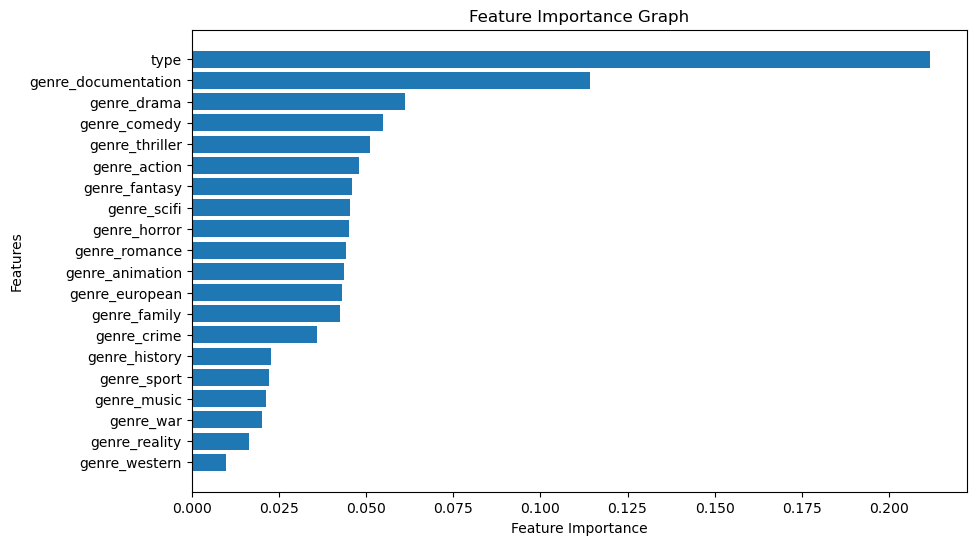

In [25]:
# Plot feature importance graph
# Fit the random forest regressor model to the data
forest_regression.fit(X, y)
# Extract the importance of each feature from the fitted model
feature_importances = forest_regression.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize = (10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Graph')
plt.show()

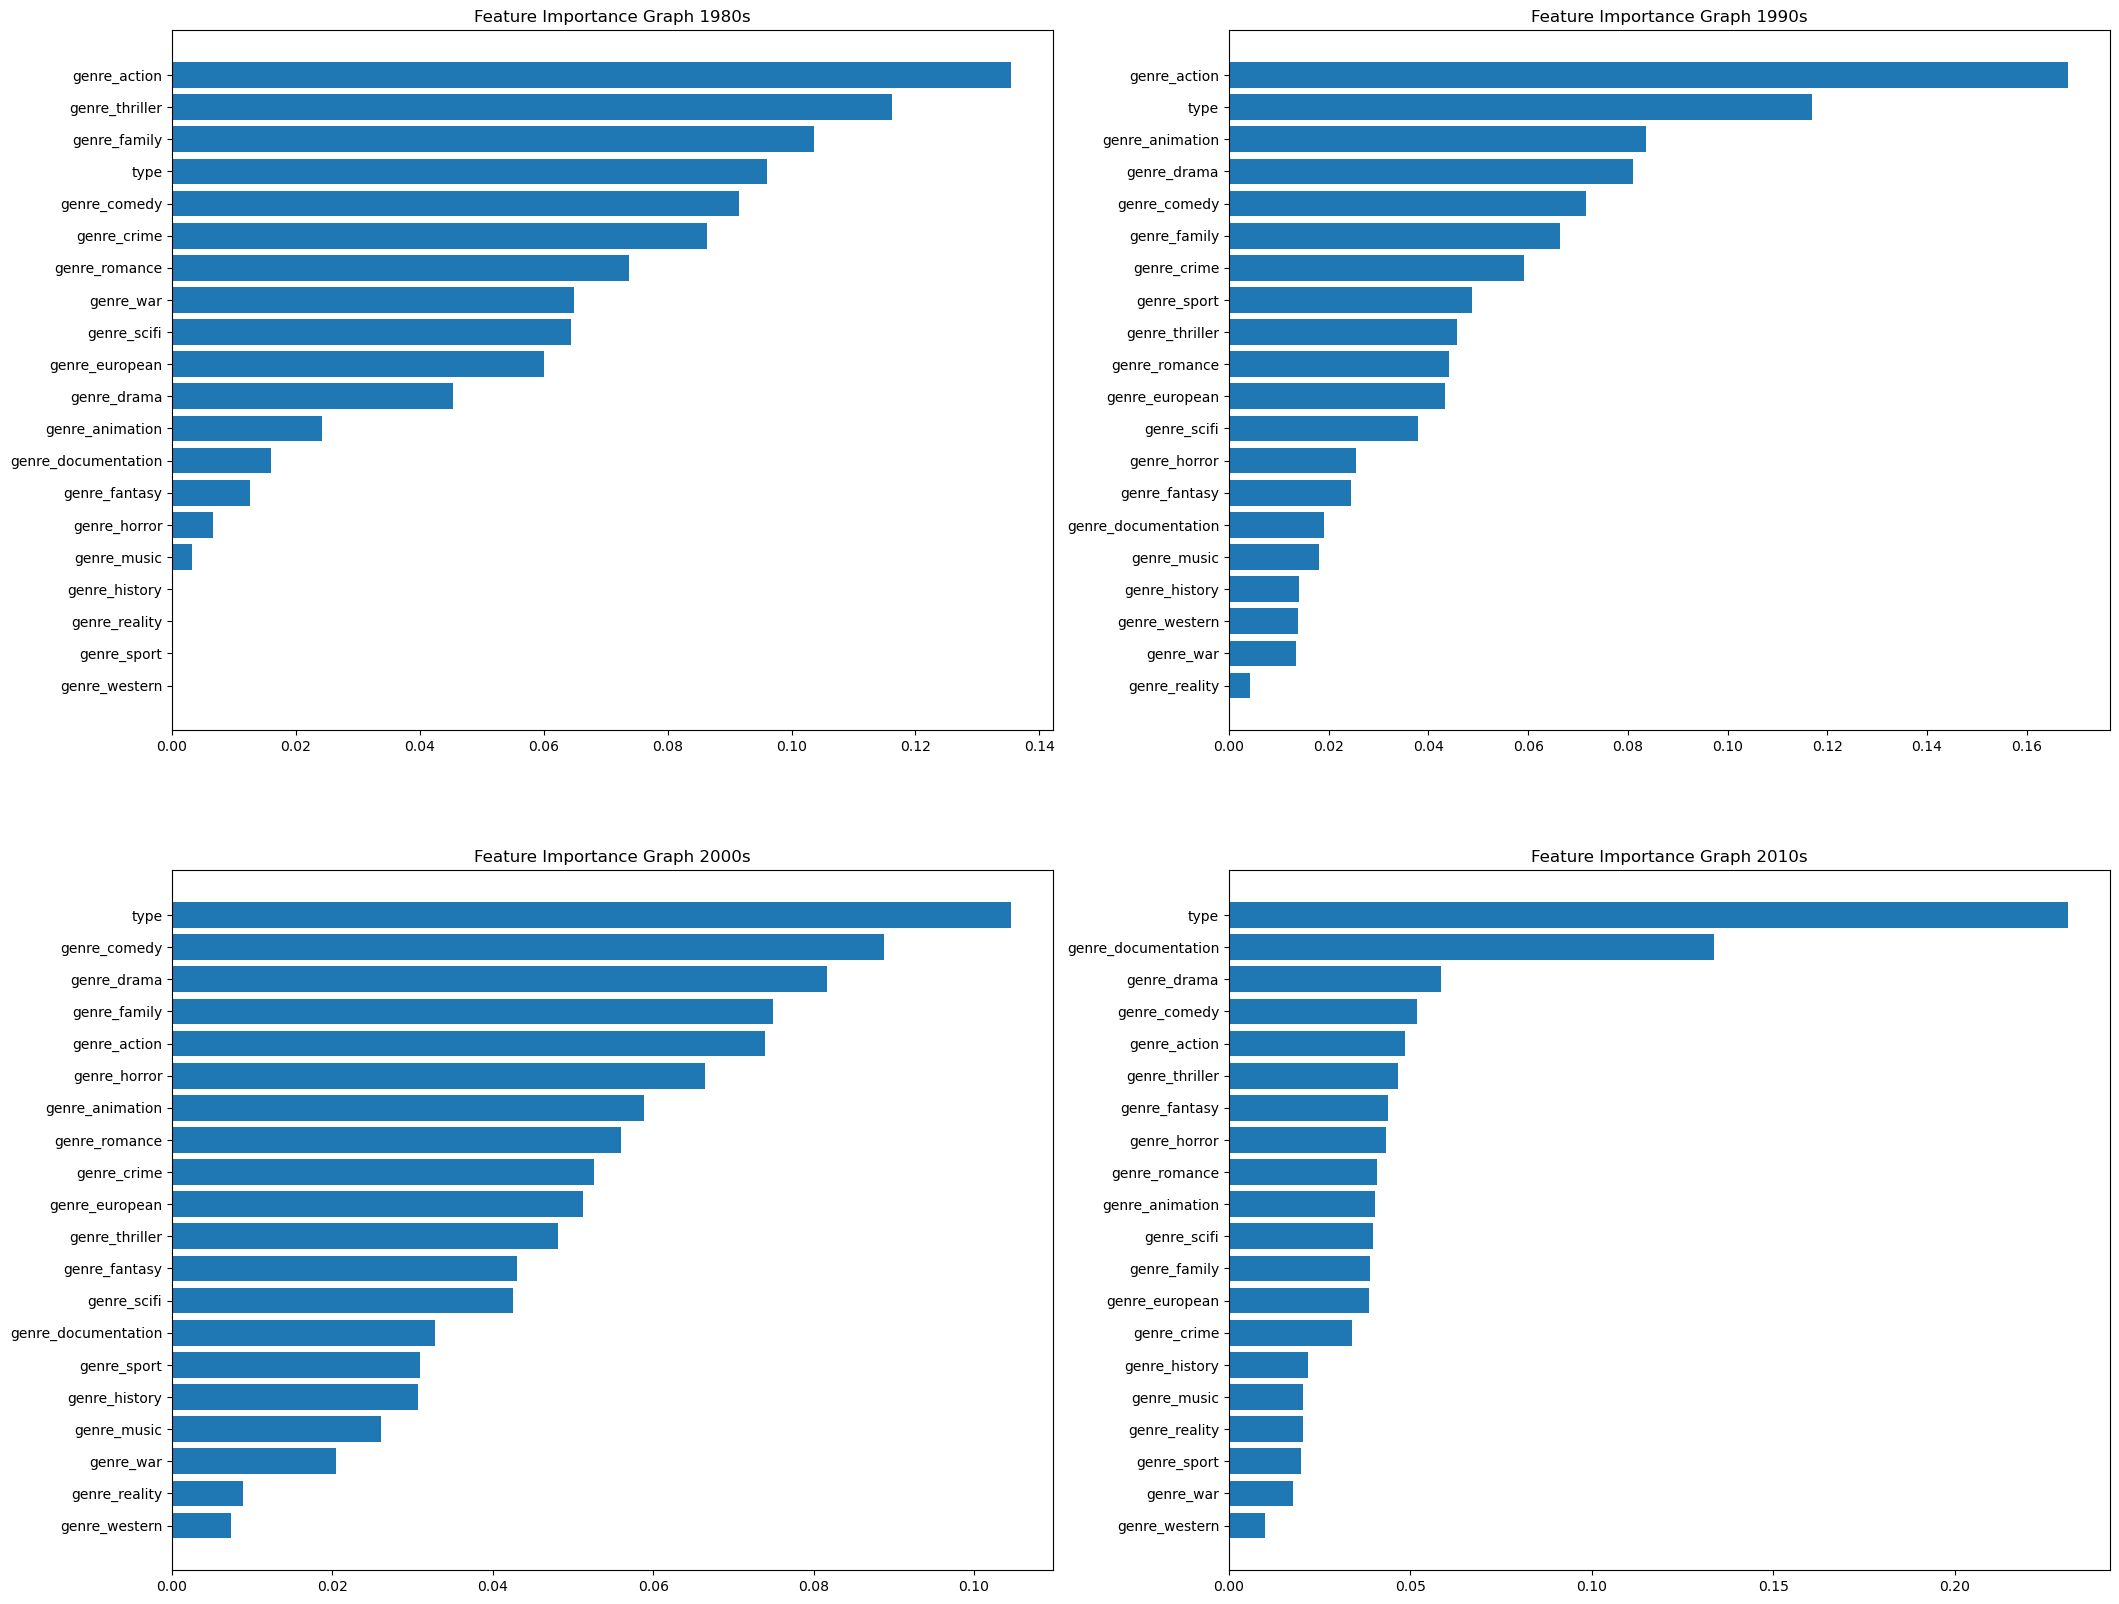

In [26]:
# Plot feature importance graph for each decade

# Pick decade bins
decades = [80, 90, 100, 110]

figure, axis = plt.subplots(2, 2)

# Plot subplot for each decade
for decade in decades:

    # Create new dataframe based on decade
    df_decade = df_cleaned[df_cleaned['decades'] == decade][kept_col]

    # Specify features and target
    X = df_decade.drop(columns=['imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'])
    y = df_decade['imdb_score']

    # Fit decade dataframe to random forest model
    forest_regression.fit(X, y)

    # Extract the importance of each feature from the fitted model
    feature_importances = forest_regression.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(feature_importances)

    # Specify subplot for each decade
    if (decade == 80):
        x1 = 0
        y1 = 0
        dec = '1980s'
    elif (decade == 90):
        x1 = 0
        y1 = 1
        dec = '1990s'
    elif (decade == 100):
        x1 = 1
        y1 = 0
        dec = '2000s'
    else:
        x1 = 1
        y1 = 1
        dec = '2010s'

    # Plot features and target
    axis[x1, y1].barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    axis[x1, y1].set_yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    #axis[x1, y1].set_xlabel('Feature Importance')
    #axis[x1, y1].set_ylabel('Features')
    axis[x1, y1].set_title('Feature Importance Graph ' + dec)


figure.set_figheight(20)
figure.set_figwidth(25)
plt.savefig('genre_importance.png')
plt.show()
    